<a href="https://colab.research.google.com/github/Spica08/deep-learning-from-scratch-5/blob/main/step4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# set up
import os
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
#データ準備
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#step4 混合ガウスモデル

## 4.1 身の回りにある多峰性分布
男女混合の身長の分布、アリの体長、間欠泉の噴出など

### 4.1.1 多峰性分布のデータセット

In [4]:
path = "/content/drive/MyDrive/datasets/old_faithful.txt"
xs = np.loadtxt(path)
print(xs.shape)
print(xs[0]) # 噴出時間、次回噴出までの間隔

(272, 2)
[ 3.6 79. ]


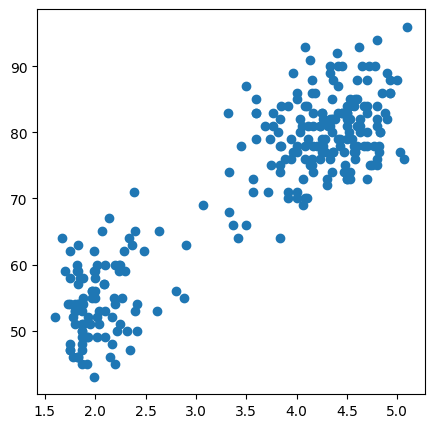

In [5]:
fig, ax = plt.subplots(figsize = (5, 5))
ax.scatter(xs[:, 0], xs[:, 1])
fig.show()

## 4.2 混合ガウスモデルのデータ生成
世の中の多峰性データ分布は、複数の正規分布を組み合わせることで表現できる。このような、複数の正規分布からなるモデルを**混合ガウスモデル(Gaussian Mixture Model)**と呼ぶ。  
GMMによる生成モデルを作るために、これまで同様2つの作業を行う  
(1) モデル化:観測データの分布がGMMによって表現できると仮定する  
(2) パラメータ推定:GMMのパラメータを推定する  
GMMはパラメータ推定が困難で、最尤推定によって解析的に解くことができない。パラメータ推定の際にはEMアルゴリズムを用いる。ここでは、パラメータ推定が終わったものとしてデータ生成を行う。

### 4.2.1 GMMによるデータ生成
データは、次の手順の繰り返しにより生成する。  
(1) 2つの正規分布の中から、ある確率分布に従って1つを選ぶ  
(2) 選んだ正規分布からデータを生成する  


### 4.2.2 データ生成を行うコード

In [6]:
# ==========学習済みのパラメータとして用意==========
# ==========2つの2次元正規分布======================
mus = np.array([[2.0, 54.50],
                [4.3, 80.0]])
covs = np.array([[[0.07, 0.44],
                  [0.44, 33.7]],
                 [[0.17, 0.94],
                  [0.94, 36.00]]])
phis = np.array([0.35, 0.65])
# ==================================================

def sample():
    z = np.random.choice(2, p = phis)
    mu, cov = mus[z], covs[z]
    x = np.random.multivariate_normal(mu, cov, 1)
    return x

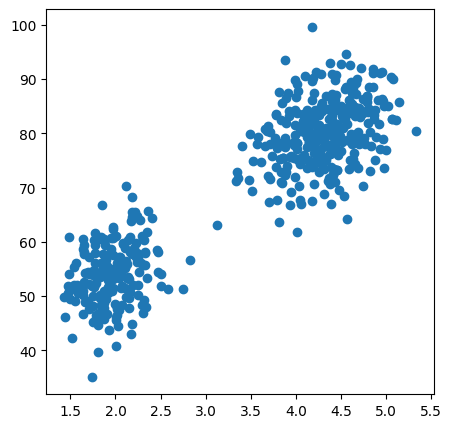

In [7]:
N = 500
xs = np.zeros([N, 2])
for i in range(N):
    xs[i] = sample()

fig, ax = plt.subplots(figsize = (5, 5))
ax.scatter(xs[:, 0], xs[:, 1])
fig.show()

## 4.3 混合ガウスモデルの式

### 4.3.1 確率の復習
2つの確率変数x, yについて考えた時、  
**同時確率(Joing Probability)** : xとyが同時に起こる確率。p(x, y)。  
**周辺確率(Marginal Probability)** : 単独の確率。ここではp(x), p(y)。  

同時確率から特定の確率変数を取り除き、周辺確率を求めることを**周辺化**と呼ぶ。  
yが離散変数の場合  
\begin{equation}
p(x) = \sum_yp(x, y)
\end{equation}
yが連続変数の場合  
\begin{equation}
p(x) = \int p(x, y)dy
\end{equation}

また、ある条件下での確率を**条件付き確率**と呼ぶ。例えばp(x|y)は、yが起きている状況のもとでのxの確率を表す。  
最後に、**乗法定理**は以下の定理である。  
\begin{equation}
p(x, y) = p(x | y)p(y)
\end{equation}

### 4.3.2 GMMの式
データは、次の手順の繰り返しにより生成する。  
(1) K個の正規分布の中から、ある確率分布に従って1つを選ぶ  
(2) 選んだ正規分布からデータを生成する  
(1)では複数の候補から1つを選ぶが、この行為に該当する確率分布はカテゴリカル分布である。カテゴリカル分布は以下のように表す。  
\begin{equation}
p(z = k;\phi) = \phi_k
\end{equation}
この分布は全て0以上で、和が1となるようなK個のパラメータを持つ。  

続いて、複数の正規分布を数式で表す。K個の正規分布のパラメータは以下の通り
\begin{equation}
\mu = \lbrace \mu_1, \mu_2, \dots, \mu_K\rbrace
\end{equation}
\begin{equation}
\sum = \left \lbrace \sum\nolimits_{1}, \sum\nolimits_{2}, \dots, \sum\nolimits_{K} \right\rbrace
\end{equation}

正規分布がK個あり、z = kが選択された時、xの従う確率分布は、
\begin{equation}
p(x| z = k;\mu, \sum) = \mathcal{N}(x; \mu_k, \sum\nolimits_k)
\end{equation}
確率の周辺化により、p(x)は、
\begin{align}
p(x) &= \sum_{k = 1}^K p(x, z = k)\\
     &= \sum_{k = 1}^K p(x| z = k)p(z = k)\\
     &= \sum_{k = 1}^K \phi_k\mathcal{N}(x; \mu_k, \sum\nolimits_k)
\end{align}
GMMの式は、各正規分布に対して重み$\phi_k$がかけられ、それらを全て足し合わせることで表される。また、この時のzはデータからは観測されないパラメータであるが、これを**潜在変数**と呼ぶ。

### 4.3.3 GMMの実装

In [9]:
# ==========学習済みのパラメータとして用意==========
# ==========2つの2次元正規分布======================
mus = np.array([[2.0, 54.50],
                [4.3, 80.0]])
covs = np.array([[[0.07, 0.44],
                  [0.44, 33.7]],
                 [[0.17, 0.94],
                  [0.94, 36.00]]])
phis = np.array([0.35, 0.65])
# ==================================================

def multivariate_normal(x, mu, cov):
    det = np.linalg.det(cov)
    inv = np.linalg.inv(cov)
    D = len(x)
    z = 1 / np.sqrt((2 * np.pi) ** D * det)
    y = z * np.exp((x - mu).T @ inv @ (x - mu) / -2.0)
    return y

def gmm(x, phis, mus, covs):
    K = len(phis)
    y = 0
    for k in range(K):
        phi, mu, cov = phis[k], mus[k], covs[k]
        y += phi * multivariate_normal(x, mu, cov)
    return y

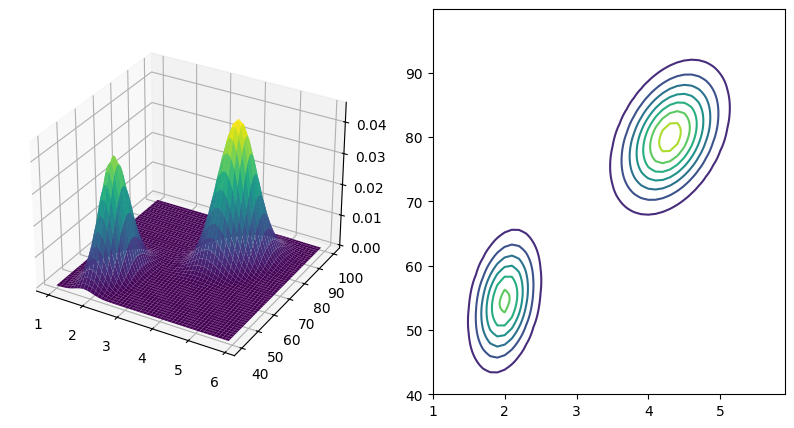

In [15]:
xs = np.arange(1, 6, 0.1)
ys = np.arange(40, 100, 0.1)
X, Y = np.meshgrid(xs, ys)
Z = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        x = np.array([X[i, j], Y[i, j]])
        Z[i, j] = gmm(x, phis, mus, covs)

fig = plt.figure(figsize = (10, 5))
ax1 = fig.add_subplot(1, 2, 1, projection = "3d")
ax1.plot_surface(X, Y, Z, cmap = 'viridis')

ax2 = fig.add_subplot(1, 2, 2)
ax2.contour(X, Y, Z)

fig.show()

## 4.4 パラメータ推定の難所

### 4.4.1 GMMのパラメータ推定
GMMの確率密度関数は以下
\begin{align}
p(x;\phi, \mu, \sum) &= \sum_{k = 1}^K \phi_k\mathcal{N}(x; \mu_k, \sum\nolimits_k)
\end{align}
ここでサンプル$D = \lbrace x^{(1)}, x^{(2)}, \dots, x^{(n)}\rbrace$が得られた場合を考える。また、パラメータ{φ, μ, Σ}はまとめてθで表す。この時尤度$p(D;\theta)$は、
\begin{align}
p(D;\theta) &= p(x^{(1)};\theta)p(x^{(2)};\theta) \dots p(x^{(n)};\theta)\\
&= \prod_{n = 1}^N p(x^{(n)};\theta)
\end{align}
で表される。これまでと同様に対数尤度が最大となるパラメータを見つけたいので対数尤度を考えて、
\begin{align}
logp(D;\theta) &= log \prod_{n = 1}^N p(x^{(n)};\theta)\\
               &= \sum_{n = 1}^N log p(x^{(n)};\theta)\\
               &= \sum_{n = 1}^N log \left(\sum_{k = 1}^K \phi_k\mathcal{N}(x; \mu_k, \sum\nolimits_k)\right)
\end{align}
勾配が0となるパラメータを探したいので、
\begin{equation}
\frac{\partial{L}}{\partial\phi} = 0  \\
\frac{\partial{L}}{\partial\mu} = 0  \\
\frac{\partial{L}}{\partial\sum} = 0
\end{equation}
を解く必要がある。一方で、この$log\sum\dots$という形はlog-sumと呼ばれる有名な形で解析に解くことが難しい。したがって、GMMのパラメータ推定は解析的に解くことができない。そこでEMアルゴリズムを用いることで対数尤度を大きくするパラメータの効率的な探索を行うことで解決する。